Chương trình bao gồm code để đánh giá mô hình đã train trên nguồn dữ dữ liệu Planet của Thái Bình, Việt Nam

In [1]:
import rasterio 
import geopandas as gpd
from rasterio.transform import rowcol
import pandas as pd
import re
import os

## Visualize Real and Predicted Values and Metrics
This plot shows the real and predicted soil moisture values for each pixel.

(Đánh giá bằng các thông số và biểu diễn trên biểu đồ)

Đánh giá trên một điểm trong khoảng thời gian 2 năm, vẽ biểu đồ  so sánh chu kỳ thay đổi độ ẩm đất của Ground truth và dự đoán 

(0.1, 0.6)

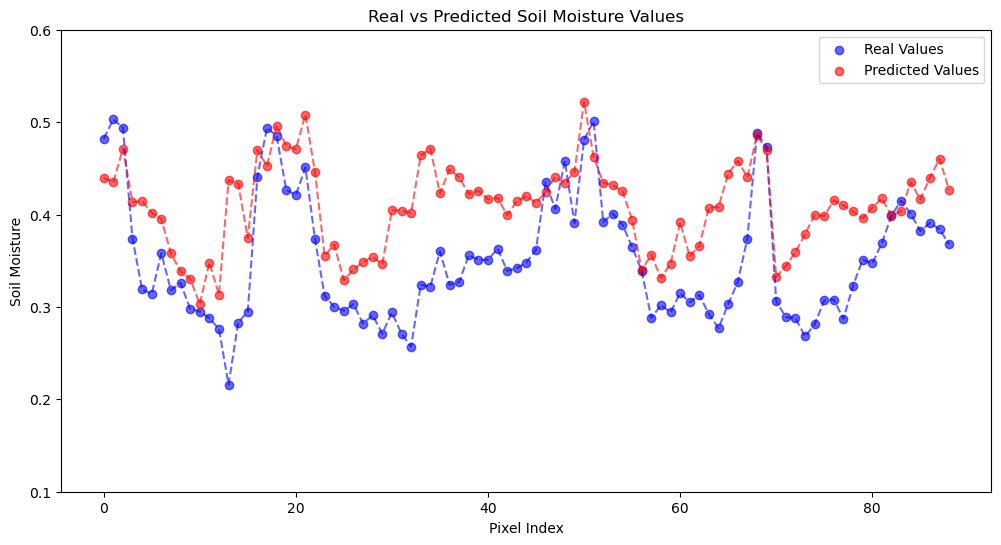

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def normalizingData(X, min_per, max_per):
    temp=(X - min_per) / (max_per - min_per)
    temp[temp>1]=1
    temp[temp<0]=0
    return temp

# Load real and predicted values
# After running inference in inference_ensemble_test.py, we will ouput 'data_pre/output_result.csv' containing predicted soil moistures
predicted = pd.read_csv('data_pre/output_result.csv')
gt = pd.read_csv('100m_data/output_tb/output_ndvi250_first/THAIBINH_101.csv')

# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else None
predicted_values = predicted['Prediction']

df = {'real values' : real_values, 'predictions' : predicted_values}
df = pd.DataFrame(df)

# Create a point plot
plt.figure(figsize=(12, 6))
if real_values is not None:
    plt.scatter(range(len(real_values)), real_values, label='Real Values', color='blue', alpha=0.6)
    plt.plot(range(len(real_values)), real_values, color='blue', alpha=0.6, linestyle='--')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', color='red', alpha=0.6)
plt.plot(range(len(predicted_values)), predicted_values, color='red', alpha=0.6, linestyle='--')

plt.xlabel('Pixel Index')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.ylim(0.1, 0.6)

Đánh giá trên một điểm trong khoảng thời gian 2 năm, vẽ biểu đồ  so sánh chu kỳ thay đổi độ ẩm đất của 3 nguồn Planet, Prediction và SMAP  

(0.1, 0.6)

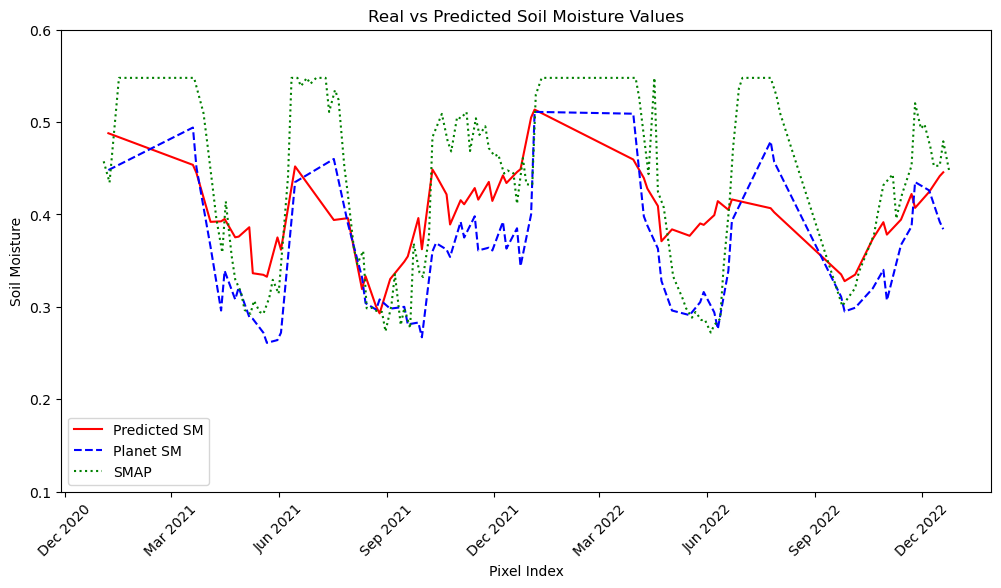

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def normalizingData(X, min_per, max_per):
    temp=(X - min_per) / (max_per - min_per)
    temp[temp>1]=1
    temp[temp<0]=0
    return temp

# Load real and predicted values
predicted = pd.read_csv('data_pre/output_result.csv')
gt = pd.read_csv('100m_data/output_tb/output_ndvi250_first/THAIBINH_130.csv')
smap = pd.read_csv('100m_data/output_tb/smap/130.csv')
# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else None
date_list = gt['date'] if 'date' in gt.columns else None
date_list = pd.to_datetime(date_list).to_list()
predicted_values = predicted['Prediction']
smap_values = smap['sm'] if 'sm' in smap.columns else None 
smap_dates = smap['date'] if 'date' in smap.columns else None 
smap_dates = pd.to_datetime(smap_dates).to_list()

df = {'real values' : real_values, 'predictions' : predicted_values}
df = pd.DataFrame(df)

# Create a point plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(date_list, predicted_values, color='red', alpha=1.0, label = 'Predicted SM')
if real_values is not None:
    ax.plot(date_list, real_values, color='blue', alpha=1.0, linestyle = '--', label = 'Planet SM')
ax.plot(smap_dates, smap_values, color = 'green', alpha=1.0, linestyle = ':', label = 'SMAP')

# Format x-axis as dates 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation = 45)

plt.xlabel('Pixel Index')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.ylim(0.1, 0.6)

Đánh giá tất cả các giá trị sm thu được của toàn bộ điểm trên Thái Bình và đánh giá bằng các chỉ số RMSE. MAE

(12393,)
12393


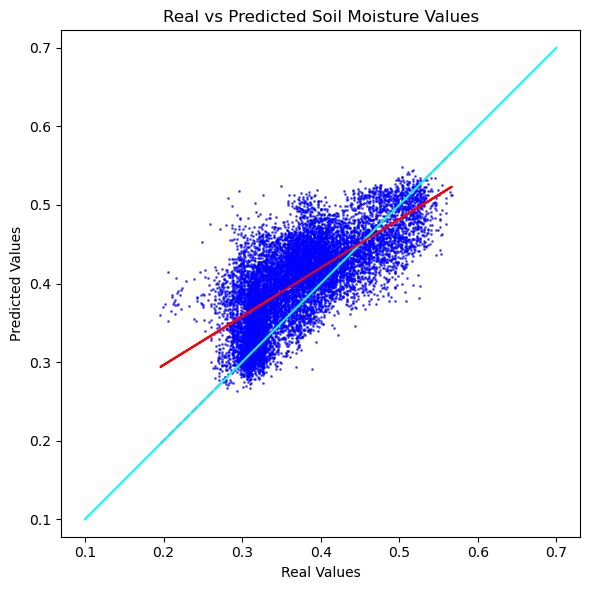

RMSE: 0.0543
Unbiased RMSE (ubRMSE): 0.0454
MAE: 0.0432
Pearson corr 0.7147


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats

# Load real and predicted values
predicted = pd.read_csv('/mnt/data2tb/Transfer-DenseSM-E_pack/output/output_result.csv')
gt = pd.read_csv('training_data/100m/thaibinh/tb_merged.csv')
# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else gt['sm']
predicted_values = predicted['Prediction']

print(real_values.shape)

mse = mean_squared_error(real_values, predicted_values)
rmse = np.sqrt(mse)
pearson_corr, pearson_p = scipy.stats.pearsonr(real_values, predicted_values)

# Calculate unbiased RMSE (ubRMSE)
bias = np.mean(predicted_values - real_values)
ubrmse = np.sqrt(np.mean(((predicted_values - real_values) - bias) ** 2))

# Calculate MAE
mae = mean_absolute_error(real_values, predicted_values)

# fit a trend line (linear regression) 
z = np.polyfit(real_values, predicted_values, 1)
p = np.poly1d(z)

print(len(real_values))
plt.figure(figsize = (6,6))
plt.scatter(real_values, predicted_values, color='blue', alpha=0.6, s=1)
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], 'r--')
plt.plot([0.1, 0.7], [0.1, 0.7], label='Ideal (y = x)', color = 'cyan')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Soil Moisture Values')
plt.plot(real_values, p(real_values), "r-", label = 'Trend Line')

plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"RMSE: {rmse:.4f}")
print(f"Unbiased RMSE (ubRMSE): {ubrmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Pearson corr {pearson_corr:.4f}")